In [51]:
!pip install yfinance
import yfinance as yf
data = yf.download('SPY', start = '1993-01-29')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.884184,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,26.068277,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,26.123499,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,26.399649,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.510111,531500
...,...,...,...,...,...,...
2021-04-12,410.850006,411.929993,410.200012,411.640015,411.640015,56704900
2021-04-13,411.529999,413.529999,411.119995,412.859985,412.859985,56551000
2021-04-14,412.829987,413.959991,410.869995,411.450012,411.450012,61659900


In [52]:
type(data)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.884184,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.068277,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.123499,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.399649,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.510111,531500


In [53]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7.105000e+03
mean,146.139273,147.006696,145.175264,146.139216,120.783623,8.455025e+07
std,75.043323,75.378812,74.674427,75.054372,80.494550,9.625266e+07
min,43.343750,43.531250,42.812500,43.406250,25.571209,5.200000e+03
25%,100.139999,100.930000,99.309998,100.139999,70.967690,7.915900e+06
50%,127.593750,128.399994,126.629997,127.580002,93.590233,5.864130e+07
75%,185.880005,187.149994,184.649994,186.199997,162.745758,1.204116e+08
max,417.250000,417.910004,415.730011,417.260010,417.260010,8.710263e+08


In [54]:
price_df = data.loc[:, ['Adj Close']].copy()
price_df.head()

,Adj Close
Date,
1993-01-29,25.884184
1993-02-01,26.068277
1993-02-02,26.123499
1993-02-03,26.399649
1993-02-04,26.510111


In [55]:
price_df['center'] = price_df['Adj Close'].rolling(window = 20).mean()
price_df.iloc[18:25]

,Adj Close,center
Date,,
1993-02-25,26.123499,NaN
1993-02-26,26.160336,26.082084
1993-03-01,26.086683,26.092208
1993-03-02,26.473289,26.112459
1993-03-03,26.583761,26.135472
1993-03-04,26.436472,26.137313
1993-03-05,26.362822,26.129949


In [56]:
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(window = 20).std()
price_df.iloc[18:25]

,Adj Close,center,ub
Date,,,
1993-02-25,26.123499,NaN,NaN
1993-02-26,26.160336,26.082084,26.748047
1993-03-01,26.086683,26.092208,26.751629
1993-03-02,26.473289,26.112459,26.793312
1993-03-03,26.583761,26.135472,26.848262
1993-03-04,26.436472,26.137313,26.853160
1993-03-05,26.362822,26.129949,26.832555


In [57]:
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(window = 20).std()
price_df.iloc[18:25]

,Adj Close,center,ub,lb
Date,,,,
1993-02-25,26.123499,NaN,NaN,NaN
1993-02-26,26.160336,26.082084,26.748047,25.416120
1993-03-01,26.086683,26.092208,26.751629,25.432788
1993-03-02,26.473289,26.112459,26.793312,25.431606
1993-03-03,26.583761,26.135472,26.848262,25.422683
1993-03-04,26.436472,26.137313,26.853160,25.421467
1993-03-05,26.362822,26.129949,26.832555,25.427343


In [58]:
n = 20
sigma = 2
def bollinger_band(price_df, n, sigma):
  bb = price_df.copy()
  bb['center'] = price_df['Adj Close'].rolling(n).mean()
  bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std()
  bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std()
  return bb

bollinger = bollinger_band(price_df, n, sigma)

In [59]:
base_date = '2009-01-02'
sample = price_df.loc[base_date:]
sample.head()
book = sample[['Adj Close']].copy()
book['trade'] = ''
book.head()

,Adj Close,trade
Date,,
2009-01-02,72.786407,
2009-01-05,72.700264,
2009-01-06,73.185722,
2009-01-07,70.993355,
2009-01-08,71.283081,


In [61]:
def tradings(sample, book):
  for i in sample.index:
    if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']:
      book.loc[i, 'trade'] = ''
    elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']:
      if book.shift(1).loc[i, 'trade'] == 'buy':
        book.loc[i, 'trade'] = 'buy'
      else:
        book.loc[i, 'trade'] = 'buy'
    elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']:
      if book.shift(1).loc[i, 'trade'] == 'buy':
        book.loc[i, 'trade'] = 'buy'
      else:
        book.loc[i, 'trade'] = ''
  return (book)

book = tradings(sample, book)
book.tail(100)

,Adj Close,trade
Date,,
2020-11-20,352.666718,buy
2020-11-23,354.780731,buy
2020-11-24,360.497559,buy
2020-11-25,359.941772,buy
2020-11-27,360.944214,buy
...,...,...
2021-04-12,411.640015,
2021-04-13,412.859985,
2021-04-14,411.450012,


In [62]:
def returns(book):
  rtn = 1.0
  book['return'] = 1
  buy = 0.0
  sell = 0.0
  for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
      buy = book.loc[i, 'Adj Close']
      print('진입일 : ' , i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
      sell = book.loc[i, 'Adj Close']
      rtn = (sell - buy) / buy + 1
      book.loc[i, 'return'] = rtn
      print('청산일 : ', i, 'long 진입가격 : ', buy, ' | long 청산가격 : ', sell, ' | return: ', round(rtn, 4))

      if book.loc[i, 'trade'] == '':
        buy = 0.0
        sell = 0.0

      acc_rtn = 1.0
      for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn
        book.loc[i, 'acc return'] = acc_rtn

      print ('Accumulated return : ', round(acc_rtn, 4))
      return (round(acc_rtn, 4))

In [63]:
#import matplotlib.pylab as plt
#book['acc return'].plot()

print(returns(book))

진입일 :  2009-01-20 00:00:00 long 진입가격 :  63.08521270751953
청산일 :  2009-03-23 00:00:00 long 진입가격 :  63.08521270751953  | long 청산가격 :  64.83792877197266  | return:  1.0278
Accumulated return :  1.0278
1.0278


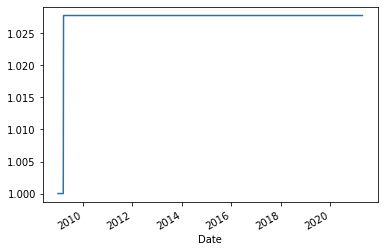

In [64]:
import matplotlib.pylab as plt
book['acc return'].plot()